# Project 2

Author: Leenah Hamdy

Date: 12/9/24

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import zscore

### Preprocessing

Only raw counts were supplied with this paper, so I processed the data using pydeseq2 for differential expression analysis.

In [17]:
#read in counts data and drop gene_name column as it is unnecessary for analysis
counts = pd.read_csv("GSE221115_R-G-spMN.txt", sep='\t').drop("gene_name",axis=1) 
counts

,gene_id,G1,G2,G3,R1,R2,R3
0,ENSMUSG00000000001,72,80,141,71,43,127
1,ENSMUSG00000000003,0,0,0,0,0,0
2,ENSMUSG00000000028,13,6,18,0,1,0
3,ENSMUSG00000000031,0,0,0,0,2,0
4,ENSMUSG00000000037,4,0,0,0,1,0
...,...,...,...,...,...,...,...
53853,ENSMUSG00000116995,14,0,13,61,0,11
53854,ENSMUSG00000116996,0,0,0,0,0,0
53855,ENSMUSG00000116997,0,0,0,0,0,0
53856,ENSMUSG00000116998,0,0,0,0,0,0


In [18]:
#set the index to be gene_id (needed for DESeq2)
counts = counts.set_index("gene_id")
counts

,G1,G2,G3,R1,R2,R3
gene_id,,,,,,
ENSMUSG00000000001,72,80,141,71,43,127
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,13,6,18,0,1,0
ENSMUSG00000000031,0,0,0,0,2,0
ENSMUSG00000000037,4,0,0,0,1,0
...,...,...,...,...,...,...
ENSMUSG00000116995,14,0,13,61,0,11
ENSMUSG00000116996,0,0,0,0,0,0
ENSMUSG00000116997,0,0,0,0,0,0


In [19]:
#filter out rows that only contain 0s
counts = counts[counts.sum(axis = 1) > 0]
counts


,G1,G2,G3,R1,R2,R3
gene_id,,,,,,
ENSMUSG00000000001,72,80,141,71,43,127
ENSMUSG00000000028,13,6,18,0,1,0
ENSMUSG00000000031,0,0,0,0,2,0
ENSMUSG00000000037,4,0,0,0,1,0
ENSMUSG00000000049,24,5,16,27,23,0
...,...,...,...,...,...,...
ENSMUSG00000116976,3,0,0,0,0,0
ENSMUSG00000116980,0,0,2,0,0,0
ENSMUSG00000116984,6,0,0,0,0,0


In [20]:
#get sample list from counts dataframe
samples = list(counts.columns)
samples

['G1', 'G2', 'G3', 'R1', 'R2', 'R3']

In [ ]:
#create a metadata dataframe (needed for DESeq)
#for each sample, get the type of neuron -- regenerative (R) and non-regenerative (G)
sample_info = [[i, i[0]] for i in samples]

#put sample_info into metadata dataframe
metadata = pd.DataFrame(sample_info, columns = ['sample', 'condition'])

#set sample column to be the index (needed for DESeq)
metadata = metadata.set_index("sample")
metadata

,condition
sample,
G1,G
G2,G
G3,G
R1,R
R2,R
R3,R


In [22]:
#transpose the counts dataframe to input into DESeq
counts = counts.T
counts

gene_id,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000031,ENSMUSG00000000037,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,...,ENSMUSG00000116959,ENSMUSG00000116960,ENSMUSG00000116964,ENSMUSG00000116970,ENSMUSG00000116972,ENSMUSG00000116976,ENSMUSG00000116980,ENSMUSG00000116984,ENSMUSG00000116989,ENSMUSG00000116995
G1,72,13,0,4,24,88,165,956,89,2374,...,0,6,6,0,0,3,0,6,11,14
G2,80,6,0,0,5,83,63,322,6,2494,...,0,0,0,0,0,0,0,0,0,0
G3,141,18,0,0,16,143,97,592,97,1508,...,3,0,3,1,0,0,2,0,0,13
R1,71,0,0,0,27,150,124,433,44,1956,...,0,0,0,0,0,0,0,0,0,61
R2,43,1,2,1,23,27,31,212,34,1314,...,0,0,3,0,1,0,0,0,0,0
R3,127,0,0,0,0,74,197,319,102,1527,...,0,0,0,0,0,0,0,0,0,11


In [23]:
#make Deseq dataset
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="condition")
#run deseq
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.74 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 1.81 seconds.

Fitting LFCs...
... done in 1.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [24]:
#get statistics of R vs. G for differential expression analysis
stat_res = DeseqStats(dds, contrast = ('condition',"R", "G"))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition R vs G
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                       
ENSMUSG00000000001  84.515515       -0.356183  0.568892 -0.626099  0.531250   
ENSMUSG00000000028   5.680290       -4.850814  2.177320 -2.227883  0.025888   
ENSMUSG00000000031   0.577809        2.663581  4.289841  0.620904  0.534663   
ENSMUSG00000000037   0.737856       -1.267320  4.066582 -0.311643  0.755312   
ENSMUSG00000000049  17.074460        0.819661  1.317660  0.622058  0.533904   
...                       ...             ...       ...       ...       ...   
ENSMUSG00000116976   0.336714       -1.948040  4.324183 -0.450499  0.652351   
ENSMUSG00000116980   0.261784       -1.653760  4.348713 -0.380287  0.703732   
ENSMUSG00000116984   0.673427       -2.887404  4.271295 -0.676002  0.499039   
ENSMUSG00000116989   1.234617       -3.748069  4.244845 -0.882970  0.377253 

... done in 0.98 seconds.



In [31]:
#create a results dataframe
results = stat_res.results_df
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000000001,84.515515,-0.356183,0.568892,-0.626099,0.531250,0.981100
ENSMUSG00000000028,5.680290,-4.850814,2.177320,-2.227883,0.025888,NaN
ENSMUSG00000000031,0.577809,2.663581,4.289841,0.620904,0.534663,NaN
ENSMUSG00000000037,0.737856,-1.267320,4.066582,-0.311643,0.755312,NaN
ENSMUSG00000000049,17.074460,0.819661,1.317660,0.622058,0.533904,0.981100
...,...,...,...,...,...,...
ENSMUSG00000116976,0.336714,-1.948040,4.324183,-0.450499,0.652351,NaN
ENSMUSG00000116980,0.261784,-1.653760,4.348713,-0.380287,0.703732,NaN
ENSMUSG00000116984,0.673427,-2.887404,4.271295,-0.676002,0.499039,NaN


### Plot 1

Volcano plot of differentially expressed genes between regenerative and non-regenerative neurons. Significantly upregulated genes (log2FC > 1 and padj < 0.1) are indicated in red and significantly downregulated genes (log2FC < -1 and padj < 0.1) are indicated in blue. Recreation of figure 1E.

In [26]:
#create list of colors for volcano plot that indicate significance
#for the volcano plot in this paper, the significance thresholds were set at padj < 0.1 annd |log2FoldChange| > 1
colors = np.where((results['log2FoldChange'] > 1) & (results['padj'] < 0.1), 'red', np.where(
        (results['log2FoldChange'] < -1) & (results['padj'] < 0.1), 'blue',  # Significantly downregulated
        'gray'  # Non-significant
    )
)

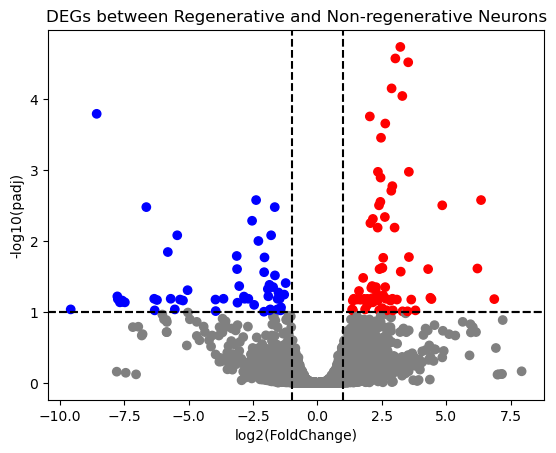

In [ ]:
#scatter log2FoldChange and -log10 scaled padj with indicated colors
plt.scatter(results['log2FoldChange'], -np.log10(results['padj']), c=colors)

#set labels
plt.xlabel("log2(FoldChange)")
plt.ylabel("-log10(padj)")
plt.title("DEGs between Regenerative and Non-regenerative Neurons")

#lines that indicate significance thresholds
plt.axvline(1, color = "black", linestyle="--")
plt.axvline(-1, color="black",linestyle="--")
plt.axhline(-np.log10(0.1), color = "black", linestyle="--")
plt.axhline(-np.log10(0.1), color="black",linestyle="--")
plt.savefig("volcano_plot.png")
plt.show()


The original paper used the R DESeq2 library to make their calculations. The python pydeseq2 package makes slightly different calculations when analyzing counts data. Because of this, the volcano plot I have produced looks slightly different than the plot included in the paper, however the overall shape of the plot aligns to the paper. I ran DESeq2 in R on the counts data and saved the calculations to the file r_deseq2_output.csv. The code used for running this analysis is included in deseq.Rmd. The following plot is a volcano plot created from the R calculations, and matches up exactly to the plot in the paper.

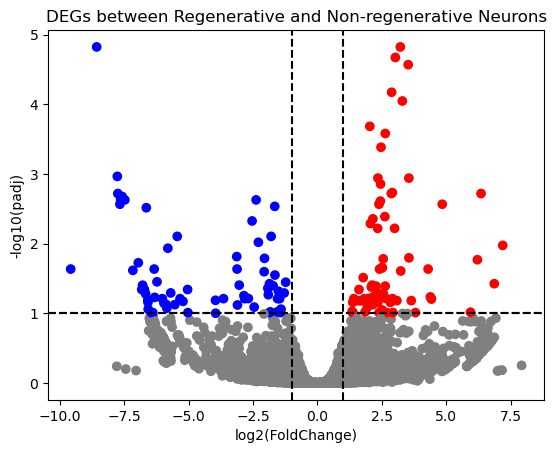

In [ ]:
#read in the csv output by the R script
r_deseq_output = pd.read_csv("r_deseq2_output.csv")

#set the colors
r_colors  = np.where((r_deseq_output['log2FoldChange'] > 1) & (r_deseq_output['padj'] < 0.1), 'red', np.where(
        (r_deseq_output['log2FoldChange'] < -1) & (r_deseq_output['padj'] < 0.1), 'blue',  # Significantly downregulated
        'gray'  # Non-significant
    )
)

#plot the datapoints
plt.scatter(r_deseq_output['log2FoldChange'], -np.log10(r_deseq_output['padj']), c=r_colors)

#set the labels
plt.xlabel("log2(FoldChange)")
plt.ylabel("-log10(padj)")
plt.title("DEGs between Regenerative and Non-regenerative Neurons")

#lines that indicate significance thresholds
plt.axvline(1, color = "black", linestyle="--")
plt.axvline(-1, color="black",linestyle="--")
plt.axhline(-np.log10(0.1), color = "black", linestyle="--")
plt.axhline(-np.log10(0.1), color="black",linestyle="--")
plt.savefig("r_volcano_plot.png")
plt.show()

### Plot 2

Heatmap of top 1000 differentially expressed genes between regenerative and non-regenerative neurons, ranked by FDR/padj (not indicated in paper, assumption). Recreation of supplementary figure 2C.

In [ ]:
#sort results by padj
sorted_results = results.sort_values('padj')

#get the top 1000 differentially expressed genes post ranking
top1000 = sorted_results.head(1000)
top1000

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000002985,1131.925246,3.218768,0.531728,6.053411,1.418102e-09,0.000018
ENSMUSG00000041607,6157.616201,3.025973,0.514693,5.879185,4.122909e-09,0.000027
ENSMUSG00000041329,144.403867,3.524700,0.608668,5.790840,7.003510e-09,0.000030
ENSMUSG00000032517,672.757626,2.879878,0.514525,5.597160,2.178914e-08,0.000071
ENSMUSG00000000296,246.502424,3.296093,0.597652,5.515071,3.486390e-08,0.000090
...,...,...,...,...,...,...
ENSMUSG00000028207,816.924644,0.747575,0.381484,1.959646,5.003718e-02,0.646438
ENSMUSG00000021843,1383.492688,-0.747444,0.380918,-1.962216,4.973731e-02,0.646438
ENSMUSG00000069355,76.181162,-1.225133,0.624991,-1.960242,4.996755e-02,0.646438


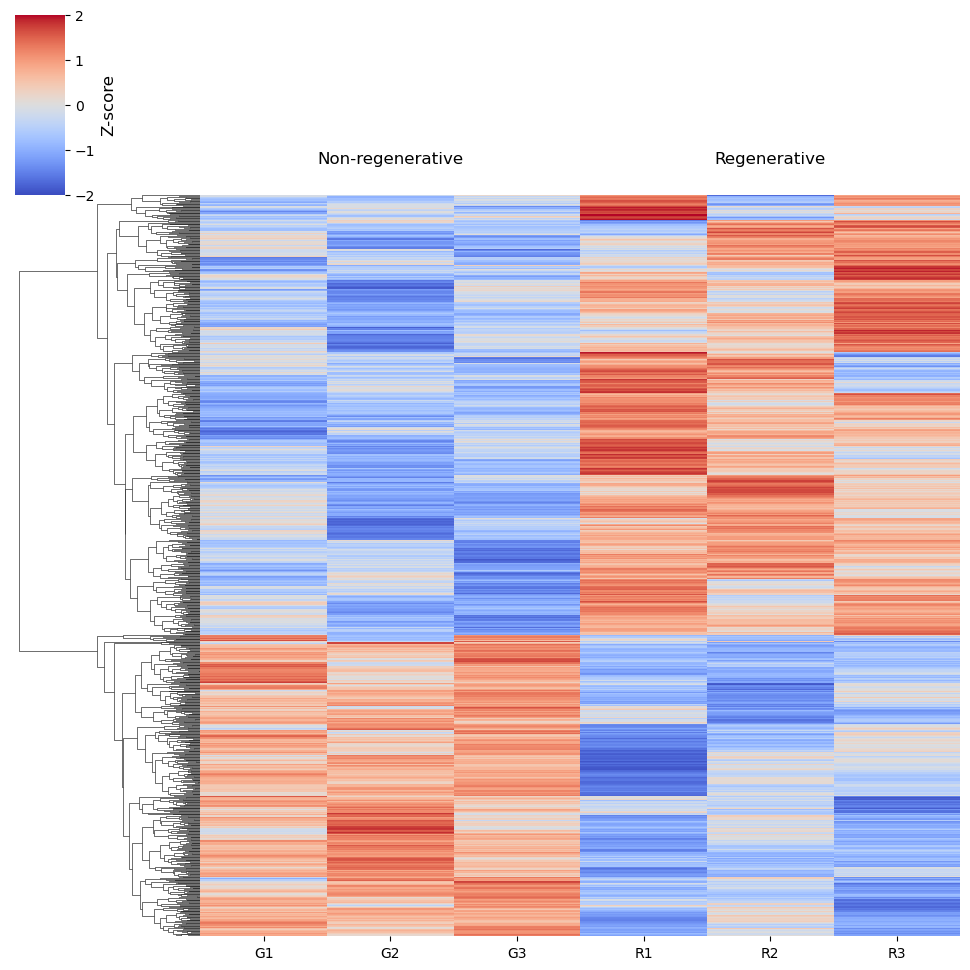

In [48]:
#log1p normalize the normed counts (ln(1+normed_count)) for proper calculation of zscores
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

#get the dds statistics for the top 1000 genes
dds_sigs = dds[:, top1000.index]

#get the normalized counts for the top 1000 genes
top1000_normalized = pd.DataFrame(dds_sigs.layers['log1p'].T,index=dds_sigs.var_names, columns=dds_sigs.obs_names)

#plot the heatmap using a zscore axis of 0 (z_score across row) and blue/red color grading
#col_cluster set to false to keep in order of the dataframe
clustergrid = sns.clustermap(top1000_normalized, z_score=0, vmin =-2, vmax = 2, cmap = 'coolwarm', col_cluster = False, yticklabels=False)

#style axes
ax = clustergrid.ax_heatmap

#Label first 3 columns with non-regenerative and last 3 columns with regenerative
ax.text(0.25, 1.05, 'Non-regenerative', fontsize=12, ha='center', va='center', transform=ax.transAxes)
ax.text(0.75, 1.05, 'Regenerative', fontsize=12, ha='center', va='center', transform=ax.transAxes)

#label the color bar with Z-score
colorbar = ax.collections[0].colorbar
colorbar.set_label('Z-score', fontsize=12)
colorbar.ax.tick_params(labelsize=10)

#remove x and y labels
ax.set_xlabel('')  
ax.set_ylabel('')

plt.savefig("heatmap.png")
plt.show()